# RNN代码实现

## 构建vocab

In [2]:
import collections
import re

file_path = 'novel.txt'

def read_txt_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    cleaned_lines = [
        re.sub('[^A-Za-z]+', ' ', line).strip().lower()
        for line in lines
    ]
    return cleaned_lines

lines = read_txt_file(file_path)

def tokenize(lines, token='word'):
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        raise ValueError(token)

def count_corpus(corpus):
    """
    统计语料中每个 token 出现的次数
    tokens:
        - 可以是 ['a', 'b', 'c']
        - 也可以是 [['a','b'], ['c','d']]
    返回：
        Counter({'a': 3, 'b': 2, ...})
    """
    all_tokens = []
    for line in corpus:          # 一行一行取
      for token in line.split():       # 行里一个个单词取
          all_tokens.append(token)


    return collections.Counter(all_tokens)

class Vocab:
    def __init__(self, tokens=None):
        """
        构建词表
        tokens: token 列表（可以是一维或二维）
        """
        if tokens is None:
            tokens = []

        # 1. 统计词频
        counter = count_corpus(tokens)

        # 2. 初始化特殊符号
        self.idx_to_token = [' ', '<unk>', '<bos>', '<eos>']
        self.token_to_idx = {
            ' ': 0,
            '<unk>': 1,
            '<bos>': 2,
            '<eos>': 3,
        }

        # 3. 按频率从高到低加入普通 token
        for token, freq in counter.most_common():
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
      return len(self.idx_to_token)

    def __getitem__(self, tokens):
      # 单个 token
      if not isinstance(tokens, (list, tuple)):
          return self.token_to_idx.get(tokens, self.token_to_idx['<unk>'])

      # token 列表
      indices = []
      for token in tokens:
          indices.append(self[token])
      return indices


    def print_vocab(self, n=10):
      print("===== Vocabulary Preview =====")
      print("index -> token")
      for i in range(min(n, len(self.idx_to_token))):
          print(f"{i:>3} -> {self.idx_to_token[i]}")

vocab = Vocab(lines)

vocab.print_vocab(n=10)

print("now ->", vocab['now'])
print("unknown ->", vocab['xyz'])
print("sentence ->", vocab[['<bos>', 'dear', 'gatsby', '<eos>']])

===== Vocabulary Preview =====
index -> token
  0 ->  
  1 -> <unk>
  2 -> <bos>
  3 -> <eos>
  4 -> the
  5 -> and
  6 -> a
  7 -> i
  8 -> of
  9 -> to
now -> 74
unknown -> 1
sentence -> [2, 1686, 29, 3]


## dataloader

In [3]:
import torch
def build_corpus_ids(lines, vocab):
    # 把text转为数字
    words = []
    for line in lines:
        if line.strip():
            words += line.split()
    return torch.tensor([vocab[w] for w in words], dtype=torch.long)


def train_iter_sequential_simple(corpus_ids, batch_size, num_steps, device='cpu'):
    corpus_ids = corpus_ids.to(device)
    N = corpus_ids.numel()
    assert N > batch_size * (num_steps + 1), "语料太短，batch_size*num_steps 太大了"

    # 截断到能整除 batch_size
    n = (N - 1) // batch_size * batch_size
    Xs = corpus_ids[:n].reshape(batch_size, -1)
    Ys = corpus_ids[1:n+1].reshape(batch_size, -1)

    batches = []   # ★ 所有 batch 放在这里

    L = Xs.shape[1]
    for t in range(0, L - num_steps + 1, num_steps):
        X = Xs[:, t:t+num_steps]
        Y = Ys[:, t:t+num_steps]
        batches.append((X, Y))   # ★ 收集起来

    return batches




corpus_ids = build_corpus_ids(lines, vocab)
print("Total tokens:", corpus_ids.shape)

batch_size = 32
num_steps = 35

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

train_iter = train_iter_sequential_simple(
    corpus_ids, batch_size, num_steps, device
)


for X, Y in train_iter:
    print("X shape:", X.shape)   # (batch_size, num_steps)
    print("Y shape:", Y.shape)
    print("X[0]:", X[0])
    print("Y[0]:", Y[0])
    break



Total tokens: torch.Size([53029])
Using device: cuda
X shape: torch.Size([32, 35])
Y shape: torch.Size([32, 35])
X[0]: tensor([   4,   81,   76,  487,    8,    4,  223,   29,   38,  487,   58,   25,
           4,  299,    8,  419, 1028,   10,    4,  420,  326,    5,  194,   92,
        1513,    8,    4,  201,   19,   63, 1219,    5,   18,  273,   63],
       device='cuda:0')
Y[0]: tensor([  81,   76,  487,    8,    4,  223,   29,   38,  487,   58,   25,    4,
         299,    8,  419, 1028,   10,    4,  420,  326,    5,  194,   92, 1513,
           8,    4,  201,   19,   63, 1219,    5,   18,  273,   63, 1965],
       device='cuda:0')


## 初始化参数

In [4]:
import math
import time

import torch
from torch import nn
import torch.nn.functional as F
def get_params(vocab_size, num_hiddens, device):
    """
    初始化循环神经网络（RNN）模型的参数。

    参数：
        vocab_size (int): 词汇表大小，即输入和输出的特征维度。
        num_hiddens (int): 隐藏层的神经元数量（隐藏单元数）。
        device (str or torch.device): 设备（如 'cpu' 或 'cuda'），参数将在此设备上初始化。

    返回：
        params (list): 包含模型参数的列表，每个参数都已启用梯度计算。
    """
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)

    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)

    return params


## 定义模型

In [5]:
def init_rnn_state(batch_size, num_hiddens, device):
    """
    初始化 RNN 的隐藏状态。

    参数：
        batch_size (int): 批量大小，即一次处理的序列数量。
        num_hiddens (int): 隐藏层的单元数（隐藏状态的大小）。

    返回：
        tuple: 包含初始化的隐藏状态张量，形状为 (batch_size, num_hiddens)。
    """
    return (torch.zeros((batch_size, num_hiddens), device=device),)

def rnn(inputs, state, params):
    """
    实现循环神经网络（RNN）的前向传播。

    参数：
        inputs (tensor): 输入数据，形状为 (时间步数量, 批量大小, 词表大小)。
        state (tuple): RNN 的初始状态，形状为 (批量大小, 隐藏单元数)。
        params (list): RNN 的参数，包括 W_xh, W_hh, b_h, W_hq, b_q。

    返回：
        outputs (tensor): 输出结果，形状为 (时间步数量 * 批量大小, 词表大小)。
        new_state (tuple): 更新后的隐藏状态。
    """
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state  # 获取隐藏状态
    outputs = []  # 存储所有时间步的输出

    # 遍历每个时间步的输入 X，形状为 (批量大小, 词表大小)
    for X in inputs:
        # 计算隐藏状态 H
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        # 计算输出 Y
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)  # 记录当前时间步的输出

    # 将所有时间步的输出拼接在一起
    return torch.cat(outputs, dim=0), (H,)


In [6]:
class RNNModel():
    """从零开始实现的循环神经网络模型"""

    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        """
        初始化 RNN 模型。

        参数：
            vocab_size (int): 词汇表大小，即输入和输出的特征数量。
            num_hiddens (int): 隐藏单元数量，决定 RNN 的记忆容量。
            device (torch.device): 计算设备。
            get_params (function): 获取模型参数的函数。
            init_state (function): 初始化隐藏状态的函数。
            forward_fn (function): RNN 的前向传播函数。
        """
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        # 调用 get_params 初始化权重和偏置
        self.params = get_params(vocab_size, num_hiddens, device)
        # 记录初始化状态函数和前向传播函数
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        """
        执行模型的前向传播。

        参数：
            X (tensor): 输入数据，形状（批量大小，序列长度）。
            state (tuple): 隐藏状态。

        返回：
            outputs (tensor): 预测结果，形状（时间步数量 * 批量大小，词表大小）。
            new_state (tuple): 更新后的隐藏状态。
        """
        # 对输入 X 进行 one-hot 编码并转换为 float32
        # 形状：(序列长度，批量大小，词表大小)
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        """
        初始化隐藏状态。

        参数：
            batch_size (int): 批量大小。
            device (torch.device): 计算设备。

        返回：
            tuple: 初始化的隐藏状态。
        """
        return self.init_state(batch_size, self.num_hiddens, device)


In [7]:
# 设置隐藏层神经元数量
num_hiddens = 512

# 创建输入数据 X，形状（批量大小，序列长度）
X = torch.arange(10).reshape((2, 5))

# 设置divice
device = 'cpu'

# 创建 RNN 模型实例
net = RNNModel(
    len(vocab),
    num_hiddens,
    device,
    get_params,
    init_rnn_state,
    rnn
)

# 初始化隐藏状态
state = net.begin_state(X.shape[0], device)

# 执行前向传播，获得预测结果 Y 和新的隐藏状态 new_state
Y, new_state = net(X.to(device), state)

# 输出预测结果形状、隐藏状态的长度以及隐藏状态的形状
Y.shape, len(new_state), new_state[0].shape


(torch.Size([10, 6163]), 1, torch.Size([2, 512]))

## predict函数

In [8]:
def predict(prefix, num_preds, net, vocab, device):
    """
    在给定的前缀字符串之后，使用 RNN 模型生成新的字符序列。

    参数：
        prefix (str): 生成序列的起始字符串（种子文本）。
        num_preds (int): 需要生成的字符数。
        net (RNNModelScratch): 训练好的循环神经网络模型。
        vocab (Vocab): 词汇表，提供字符与索引的映射关系。
        device (torch.device): 计算设备（'cpu' 或 'cuda'）。

    返回：
        str: 生成的完整文本（包含前缀和预测的新字符）。
    """
    # 初始化 RNN 的隐藏状态，batch_size=1 处理单个序列
    state = net.begin_state(batch_size=1, device=device)

    # 将 prefix 的第一个字符转换为索引并存入输出列表
    outputs = [vocab[prefix[0]]]

    # 定义一个 lambda 函数，获取当前最后一个字符的索引并转换为模型输入
    get_input = lambda: torch.tensor(
        [outputs[-1]], device=device
    ).reshape((1, 1))

    # 预热期：将 prefix 剩余字符依次输入网络，帮助 RNN 进入适当的状态
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])

    # 生成 num_preds 个新的字符
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))

    # 将输出索引列表转换回字符，并连接成字符串
    return ''.join([vocab.idx_to_token[i] for i in outputs])



predict('dear gatsby ', 10, net, vocab, device)


'dear gatsb<unk> grufflybondblameprivacydriftdiedwatchingtelattiredcareful'

## 工具函数

In [9]:
class Accumulator:
    """
    在多个变量上进行累加的工具类
    """
    def __init__(self, n):
        """
        参数:
            n (int): 需要累加的变量个数
        """
        self.data = [0.0] * n

    def add(self, *args):
        """
        将传入的值逐项累加
        """
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        """
        清零
        """
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        """
        允许用 metric[i] 的方式访问
        """
        return self.data[idx]

def grad_clipping(net, theta):
    """
    梯度裁剪，防止梯度爆炸

    参数:
        net: 模型（nn.Module 或自定义 RNN）
        theta (float): 梯度范数阈值
    """
    if isinstance(net, torch.nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params  # RNN 的参数列表

    # 计算梯度的 L2 范数
    norm = torch.sqrt(
        sum(torch.sum(p.grad ** 2) for p in params if p.grad is not None)
    )

    # 若超过阈值，则按比例缩放
    if norm > theta:
        for p in params:
            if p.grad is not None:
                p.grad[:] *= theta / norm

## 训练！！！

/tmp/ipython-input-105260341.py:16: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  self.data = [a + float(b) for a, b in zip(self.data, args)]


[epoch    1] perplexity = 1401.61
[epoch    2] perplexity = 857.12
[epoch    3] perplexity = 868.10
[epoch    4] perplexity = 859.35
[epoch    5] perplexity = 1043.24
dear gatsb<unk> thethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethe
[epoch    6] perplexity = 1047.16
[epoch    7] perplexity = 1042.33
[epoch    8] perplexity = 864.11
[epoch    9] perplexity = 846.88
[epoch   10] perplexity = 825.37
dear gatsb<unk> thethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethe
[epoch   11] perplexity = 745.66
[epoch   12] perplexity = 744.04
[epoch   13] perplexity = 803.88
[epoch   14] perplexity = 784.01
[epoch   15] perplexity = 736.00
dear gatsb<unk> athethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethethe
[e

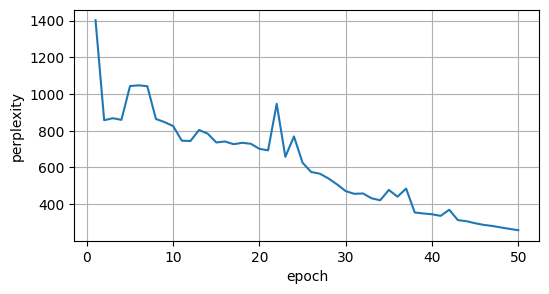


Final sample:
dear gatsb<unk> theotheroralittleandalittleoftheotheroralittleandalittleoftheotheroralittleandalittleoftheotheroralittleandalittleoftheotheroralittleandalittleoftheotheroralittle


In [10]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt

def train_epoch(net, train_iter, loss, optimizer, device, use_random_iter):
    state = None
    metric = Accumulator(2)  # [total_loss, total_tokens]

    for X, Y in train_iter:
        # 第一个batch：初始化 state
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            # 其它batch：detach，避免计算图越来越长导致“卡死”
            for s in state:
                s.detach_()

        y = Y.T.reshape(-1)          # (B, T) -> (T*B,)
        X, y = X.to(device), y.to(device)

        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()

        optimizer.zero_grad()
        l.backward()
        grad_clipping(net, 1.0)
        optimizer.step()

        metric.add(l * y.numel(), y.numel())

    return math.exp(metric[0] / metric[1])


def train(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(net.params, lr=lr)

    epochs, ppls = [], []

    for epoch in range(num_epochs):
        ppl = train_epoch(net, train_iter, loss, optimizer, device, use_random_iter)

        print(f"[epoch {epoch+1:4d}] perplexity = {ppl:.2f}")

        epochs.append(epoch + 1)
        ppls.append(ppl)

        if (epoch + 1) % 5 == 0:
            print(predict('dear gatsby ', 50, net, vocab, device))

    plt.figure(figsize=(6, 3))
    plt.plot(epochs, ppls)
    plt.xlabel('epoch')
    plt.ylabel('perplexity')
    plt.grid(True)
    plt.show()

    print("\nFinal sample:")
    print(predict('dear gatsby ', 50, net, vocab, device))



num_epochs = 50
lr = 1e-3

train(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False)
